### Formulation of the problem

It is required, based on the demographics of bank customers, their payment history and account balance, to predict their credit card defaults in the next month.

Data fields

    Home Ownership - домовладение
    Annual Income - годовой доход
    Years in current job - количество лет на текущем месте работы
    Tax Liens - налоговые обременения
    Number of Open Accounts - количество открытых счетов
    Years of Credit History - количество лет кредитной истории
    Maximum Open Credit - наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту)
    Number of Credit Problems - количество проблем с кредитом
    Months since last delinquent - количество месяцев с последней просрочки платежа
    Bankruptcies - банкротства
    Purpose - цель кредита
    Term - срок кредита
    Current Loan Amount - текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)
    Current Credit Balance - текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)
    Monthly Debt - ежемесячный долг
    Credit Score - баллы кредитного рейтинга
    Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


## Connecting libraries and scripts 

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc,
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

## Paths to directories and files 

In [2]:
from pathlib import Path

DATA_ROOT = Path('./data/training_project/')

# input
DATASET_PATH = DATA_ROOT / 'train.csv'
TEST_DATASET_PATH = DATA_ROOT / 'test.csv'


PREP_DATASET_PATH = DATA_ROOT / 'training_project_data_prep.csv'
PREP_TEST_DATASET_PATH = DATA_ROOT / 'final_project_data_prep.csv'

In [3]:
df_base = pd.read_csv(DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

df_base.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
df_base.shape

(7500, 17)

In [5]:
df_base['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [6]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()

### Data overview

In [7]:
df_base[TARGET_NAME].value_counts() # class imbalance

0    5387
1    2113
Name: Credit Default, dtype: int64

In [8]:
df_base.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [9]:
df_train = df_base.copy()

### Overview of nominative features

In [10]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

## Pass processing

In [11]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

## Fill in gaps/outliers

In [12]:
# df_base.info()

In [13]:
# df_test.info()

In [14]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None

        
    def fit(self, df):
        self.annual_median = df['Annual Income'].median()
        self.credit_score_median = df['Credit Score'].median()
        self.years_in_mode =df['Years in current job'].mode()[0]
        self.bankruptcies_mode =df['Bankruptcies'].mode()[0]
        self.current_loan_amount_median =df['Current Loan Amount'].median()
       
        
        
    def transform(self, df):
        
        #1. Passes
        
        df['Annual Income'] = df['Annual Income'].fillna(self.annual_median)
        df['Credit Score'] = df['Credit Score'].fillna(self.credit_score_median)
        df['Years in current job'] = df['Years in current job'].fillna(self.years_in_mode)
        df['Bankruptcies'] = df['Bankruptcies'].fillna(self.bankruptcies_mode)
        
        
#         df['prog_credit_score'] = 0
#         df.loc[df['Credit Score'] > 1000, 'prog_credit_score'] = 1
#         df.loc[df['Credit Score'] > 1000, 'Credit Score'] = df['Credit Score']/10
#         df.loc[df['Credit Score'] > 1000, 'Credit Score'] = self.credit_score_median


#         df['prog_current_loan_amount'] = 0
#         df.loc[df['Current Loan Amount'] == 99999999, 'prog_current_loan_amount'] = 1
#         df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = self.current_loan_amount_median
        df.loc[df['Home Ownership'].isin(['Home Mortgage', 'Have Mortgage']),'Home Ownership'] = 'Home Mortgage'
        
        df.loc[df['Tax Liens'] > 1, 'Tax Liens']= 1
 
        df.loc[df['Bankruptcies'] > 2, 'Bankruptcies']= 2
        
        df[['Tax Liens','Bankruptcies']] = df[['Tax Liens','Bankruptcies']].astype(int)
        
        # Remove:
        if 'Months since last delinquent' in df.columns:
            df.drop('Months since last delinquent', axis=1, inplace=True)
            
            
        #Dummies
       
        df['Home Ownership'] = df['Home Ownership'].map({'Home Mortgage':'1', 'Rent':'2','Own Home':'3','Have Mortgage':'4'}) 
        
       
        df['Term'] = df['Term'].map({'Long Term':'1', 'Short Term':'2'})
        
        
        df['Years in current job'] = df['Years in current job'].map({'10+ years': '10', '1 year':'1', '2 years':'2', '3 years':'3','4 years':'4', '5 years':'5', '6 years':'6', '7 years':'7', '8 years':'8',
       '9 years':'9','< 1 year':'0'}).astype(int)
        
        
        
        df['Purpose'] = df['Purpose'].map({'debt consolidation':'0', 'other':'1','home improvements':'2','business loan':'3',        
       'buy a car':'4', 'medical bills':'5', 'major purchase':'6','take a trip':'7','buy house':'8', 'small business':'9', 'wedding':'10',
                                           'moving':'11', 'educational expenses':'12', 'vacation':'13', 'renewable energy':'14'}).astype(int)
        df['Purpose'] = df['Purpose'].astype(int)
        df.loc[df['Purpose'] > 2, 'Purpose']= 1
        df['Purpose'] = df['Purpose'].astype('object')
        
        for cat_colname in df.select_dtypes(include='object').columns[:]:
            df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
    

        
        
        
        
        
        return df

In [15]:
imputer = FeatureImputer()

imputer.fit(df_base) 

df = imputer.transform(df_train)
df_final = imputer.transform(df_test)

In [16]:
# df.isna().sum()

## Correlation with basic features

In [17]:
ALL_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

NUM_FEATURE_NAMES = ['Annual Income','Number of Open Accounts','Years of Credit History',\
       'Maximum Open Credit','Number of Credit Problems','Current Loan Amount','Years in current job',\
                     'Current Credit Balance', 'Monthly Debt','Credit Score']
CAT_FEATURE_NAMES = ['Home Ownership','Tax Liens','Bankruptcies', 'Purpose']

In [18]:
df_train.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default'],
      dtype='object')

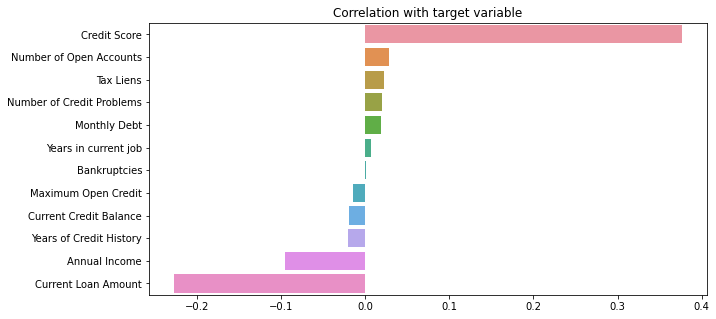

In [19]:
corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 5))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

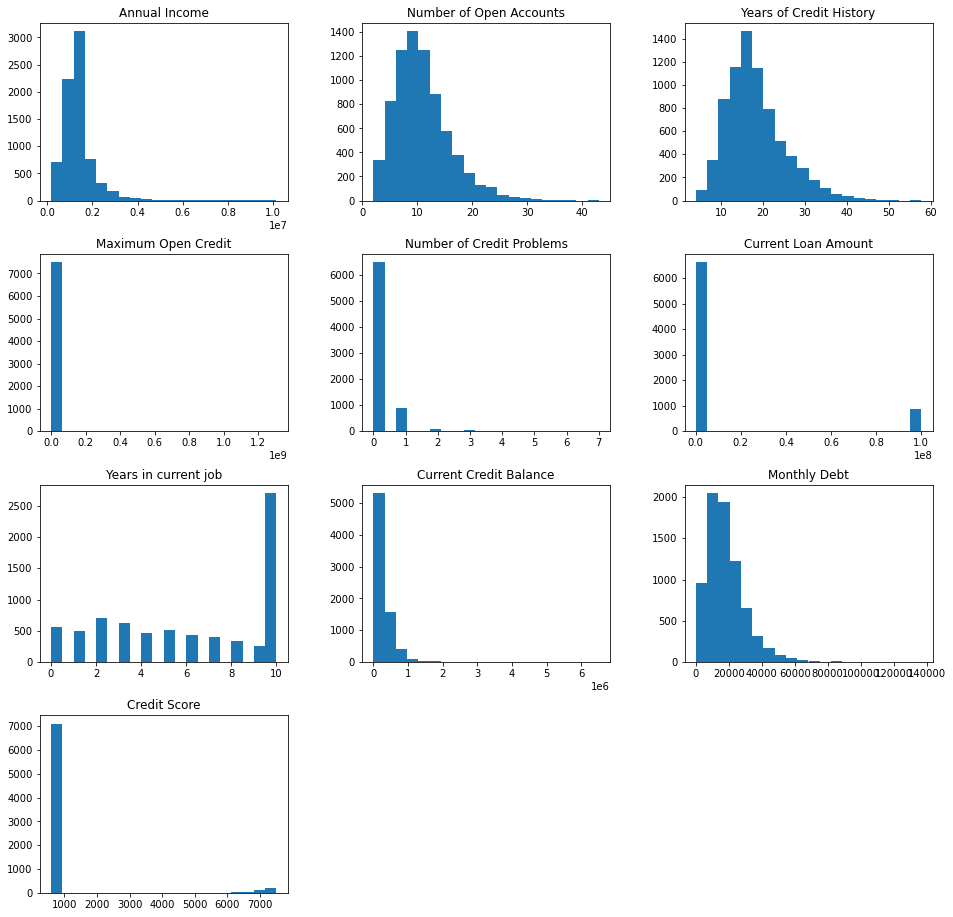

In [20]:
df[NUM_FEATURE_NAMES].hist(figsize=(16,16), bins=20, grid=False);

### Evaluation of the feature 'Credit Score' in the context of the target variable

In [21]:
credit_score_1000 = df.loc[df['Credit Score']> 1000, ['Credit Score','Credit Default']]
credit_score_1000['Credit Default'].value_counts()

1    400
Name: Credit Default, dtype: int64

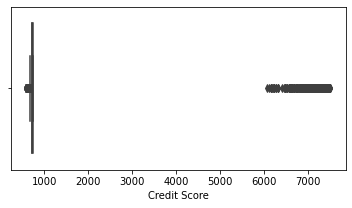

In [22]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Credit Score'], whis=1.5)

plt.xlabel('Credit Score')
plt.show()

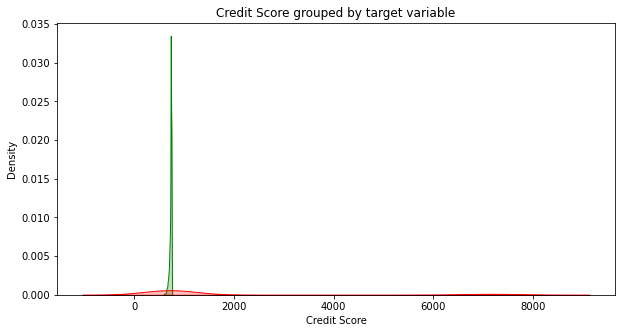

In [23]:
credit_score_with_target = df[['Credit Score', TARGET_NAME]]
credit_score = credit_score_with_target['Credit Score']
credit_score_target_0 = credit_score[credit_score_with_target[TARGET_NAME] == 0]
credit_score_target_1 = credit_score[credit_score_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()


In [24]:
shapiro(credit_score)

ShapiroResult(statistic=0.2491898536682129, pvalue=0.0)

Based on the resulting p-value, which is much less than 0.05, we can conclude that the hypothesis of "normality" is rejected.

For reliability, we will make a visual assessment of the distribution of the feature, as well as build a QQ-plot

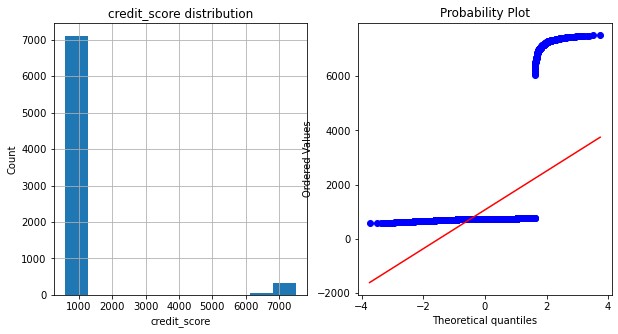

In [25]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('credit_score')
ax1.set_ylabel('Count')
ax1.set_title('credit_score distribution')
credit_score.hist()

plt.subplot(122)
probplot(credit_score, dist='norm', plot=plt)

plt.show()

Visual evaluation of the results of the Shapiro-Wilk test regarding the fact that the distribution law differs from the "normal" one, and therefore, we cannot offer a regular Student's test to test the hypothesis of equality of mat. expected signs of  'Credit Score' in groups with overdue and non-overdue payments in the next month, but we plan to conduct its non-parametric analogue - the Mann-Whitney test, which is not demanding on the distribution law.

Let us estimate the equivalence of mat. expectations, in independent groups, using the Mann-Whitney test

mannwhitneyu(credit_score_target_0, credit_score_target_1)

According to the p-value, the hypothesis about the equality of mat. expectations is rejected, but for the sake of additional verification, it is worth turning to confidence intervals.

Let's build confidence intervals for the means of each of the two groups and compare them



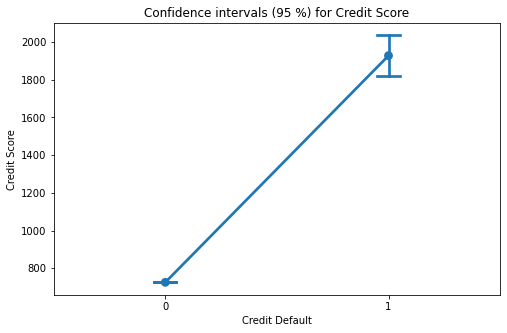

In [26]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

This graph also shows that the intervals in which the true mate should be found with 95% probability. the expectations of these two groups do not overlap, which confirms the results obtained using the Mann-Whitney test.

This means that the groups from which the sample data are taken, with the probability allowed by us (95%), have different distributions and this feature can be useful for determining the value of the target variable.

### Evaluation of the feature 'Current Loan Amount' in the context of the target variable

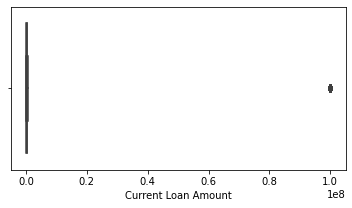

In [27]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Current Loan Amount'], whis=1.5)

plt.xlabel('Current Loan Amount')
plt.show()

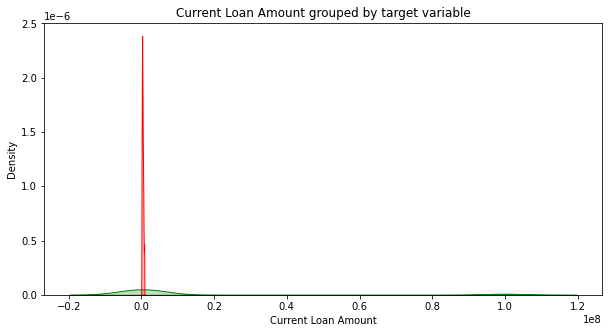

In [28]:
current_loan_amount_with_target = df[['Current Loan Amount', TARGET_NAME]]
current_loan_amount = current_loan_amount_with_target['Current Loan Amount']
current_loan_amount_target_0 = current_loan_amount[current_loan_amount_with_target[TARGET_NAME] == 0]
current_loan_amount_target_1 = current_loan_amount[current_loan_amount_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(current_loan_amount_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(current_loan_amount_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Current Loan Amount')
plt.title('Current Loan Amount grouped by target variable')
plt.show()

In [29]:
shapiro(current_loan_amount)

ShapiroResult(statistic=0.37670987844467163, pvalue=0.0)

In [30]:
mannwhitneyu(current_loan_amount_target_0, current_loan_amount_target_1)

MannwhitneyuResult(statistic=5169258.0, pvalue=2.923443678733522e-10)

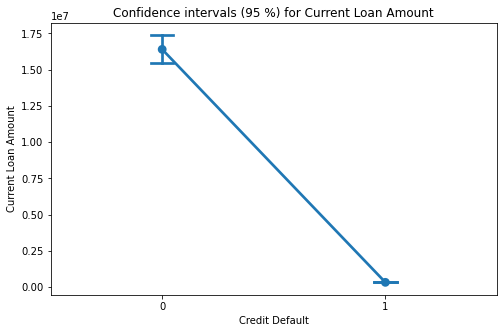

In [31]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current Loan Amount', data=current_loan_amount_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Current Loan Amount')
plt.show()

### 'Annual Income'

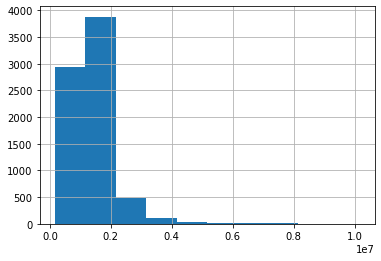

In [32]:
df['Annual Income'].hist();

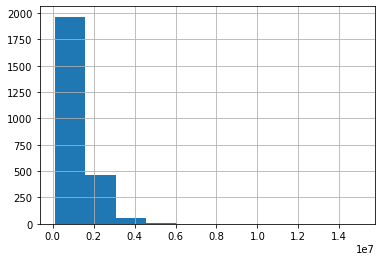

In [33]:
df_test['Annual Income'].hist();

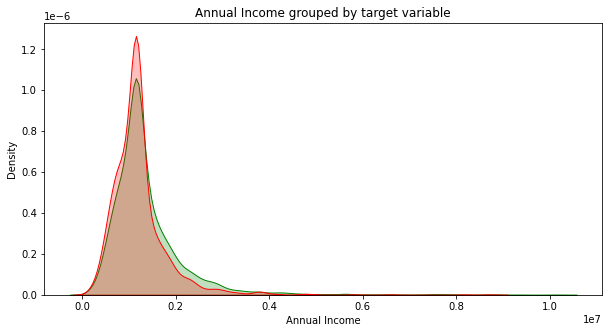

In [34]:
annual_income_with_target = df[['Annual Income', TARGET_NAME]]
annual_income = annual_income_with_target['Annual Income']
annual_income_target_0 = annual_income[annual_income_with_target[TARGET_NAME] == 0]
annual_income_target_1 = annual_income[annual_income_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_income_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(annual_income_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

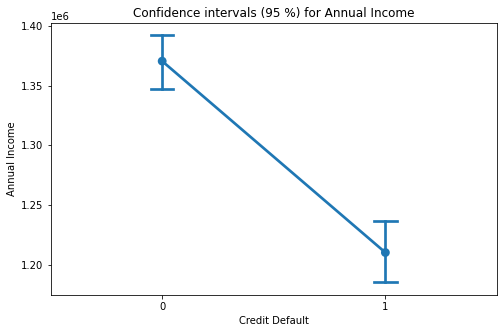

In [35]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_income_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

## Categorical Features

### feature 'Home Ownership'

In [36]:
df['Home Ownership'].value_counts()

1    3649
2    3204
3     647
Name: Home Ownership, dtype: int64

In [37]:
df_final['Home Ownership'].value_counts()

1    1232
2    1020
3     248
Name: Home Ownership, dtype: int64

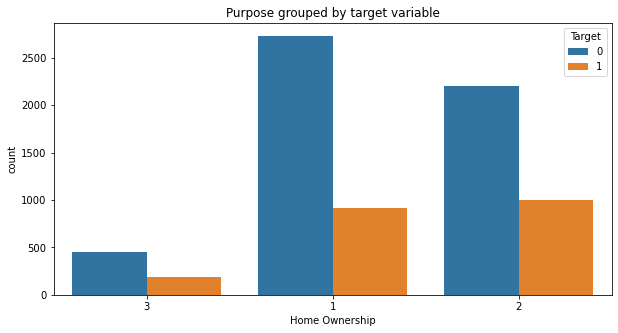

In [38]:
plt.figure(figsize=(10, 5))

sns.countplot(x='Home Ownership', hue=TARGET_NAME, data=df)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

**Hypothesis**

    Null hypothesis: expected and observed frequencies agree
     Alternative hypothesis: deviations in frequencies are beyond random fluctuations, discrepancies are statistically significant
     Criterion: Pearson Chi-Square
     Significance level: 0.05
     Critical area: double sided

In [39]:
# df['Id'] = df.index
# home_ownership_and_target_s = df.loc[df['Home Ownership'].isin(['Home Mortgage', 'Have Mortgage']), ['Id', 'Home Ownership', TARGET_NAME]]

# table = home_ownership_and_target_s.pivot_table(values='Id', index='Home Ownership', columns=TARGET_NAME, aggfunc='count')
# table

In [40]:
# chi2, p, _, _ = chi2_contingency(table)
# p

In [41]:
# plt.figure(figsize=(10, 5))

# sns.pointplot(x='Home Ownership', y=TARGET_NAME, data=df, capsize=.1,);


### 'Tax Liens'

In [42]:
df['Tax Liens'].value_counts()

0    7366
1     134
Name: Tax Liens, dtype: int64

In [43]:
df_test['Tax Liens'].value_counts()

0    2445
1      55
Name: Tax Liens, dtype: int64

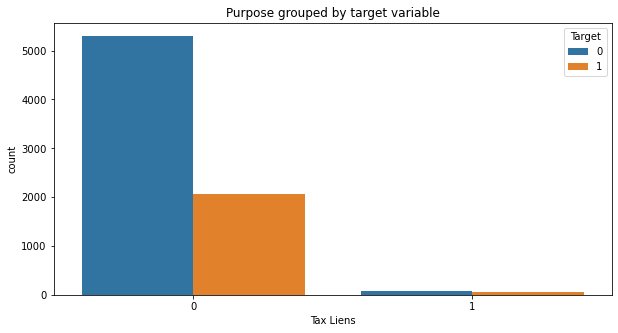

In [44]:
plt.figure(figsize=(10, 5))

sns.countplot(x='Tax Liens', hue=TARGET_NAME, data=df)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

### 'Bankruptcies'

In [45]:
df['Bankruptcies'].value_counts()

0    6674
1     786
2      40
Name: Bankruptcies, dtype: int64

In [46]:
df_test['Bankruptcies'].value_counts()

0    2255
1     234
2      11
Name: Bankruptcies, dtype: int64

### 'Purpose'

In [47]:
df['Purpose'].value_counts()

0    5944
1    1144
2     412
Name: Purpose, dtype: int64

In [48]:
df_test['Purpose'].value_counts()

0    1973
1     387
2     140
Name: Purpose, dtype: int64

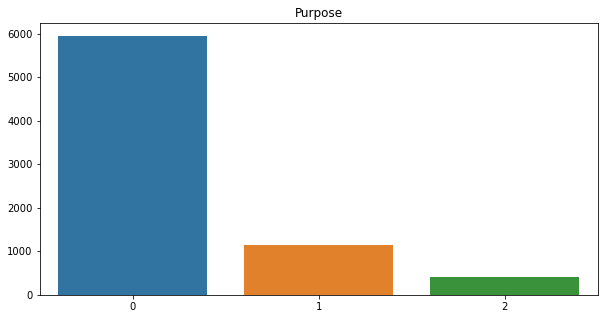

In [49]:
counts = df['Purpose'].value_counts()
    
plt.figure(figsize=(10,5))    
plt.title('Purpose')
sns.barplot(counts.index, counts.values)
    
plt.show()

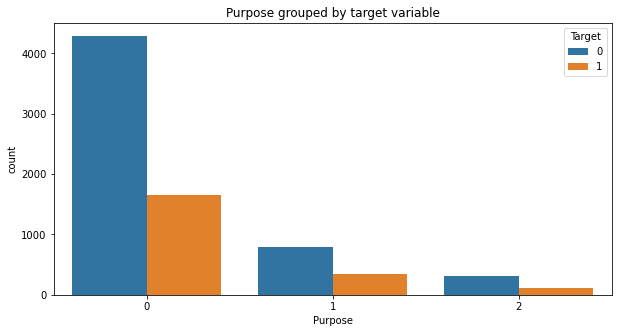

In [50]:
plt.figure(figsize=(10, 5))

sns.countplot(x='Purpose', hue=TARGET_NAME, data=df)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [51]:
df['Id'] = df.index
purpose_and_target_s = df.loc[df['Purpose'].isin([2, 1]), ['Id', 'Purpose', TARGET_NAME]]
table = purpose_and_target_s.pivot_table(values='Id', index='Purpose', columns=TARGET_NAME, aggfunc='count')
table

Credit Default,0,1
Purpose,,
1,793,351
2,304,108


In [52]:
chi2, p, _, _ = chi2_contingency(table)
p

0.10053426637413908

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Home Ownership             7500 non-null   object 
 1   Annual Income              7500 non-null   float64
 2   Years in current job       7500 non-null   int64  
 3   Tax Liens                  7500 non-null   int64  
 4   Number of Open Accounts    7500 non-null   float64
 5   Years of Credit History    7500 non-null   float64
 6   Maximum Open Credit        7500 non-null   float64
 7   Number of Credit Problems  7500 non-null   float64
 8   Bankruptcies               7500 non-null   int64  
 9   Purpose                    7500 non-null   object 
 10  Term                       7500 non-null   object 
 11  Current Loan Amount        7500 non-null   float64
 12  Current Credit Balance     7500 non-null   float64
 13  Monthly Debt               7500 non-null   float

## Feature space analysis

Correlation matrix

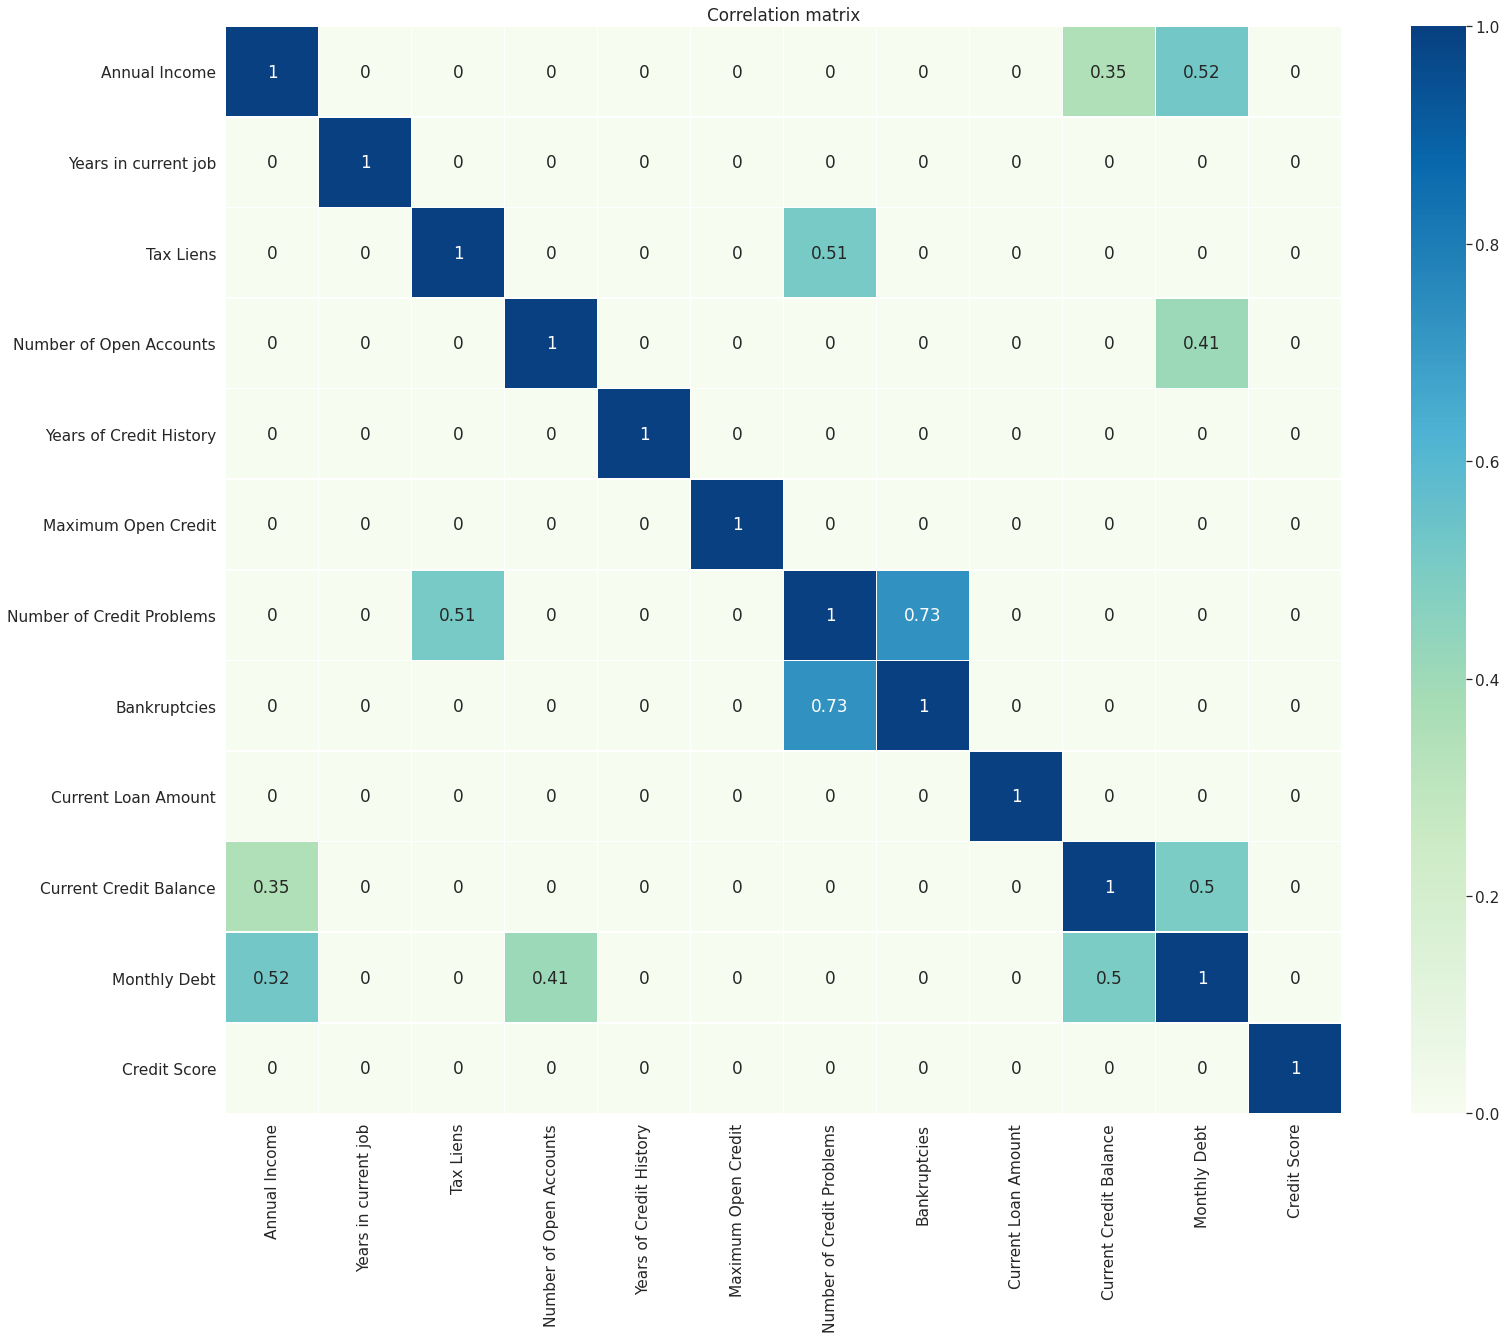

In [54]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df[BASE_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

##  Let's check the distributions of real features on the train and test

Annual Income
MannwhitneyuResult(statistic=9361624.5, pvalue=0.45720685796373933)


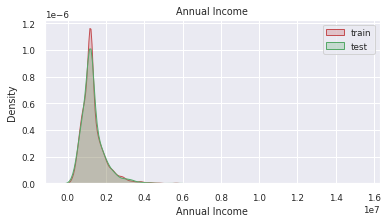

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


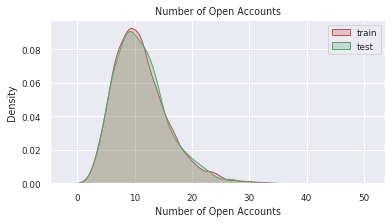

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


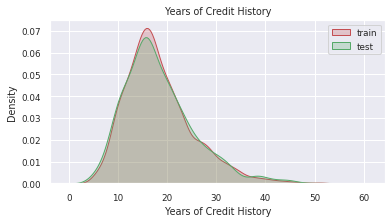

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


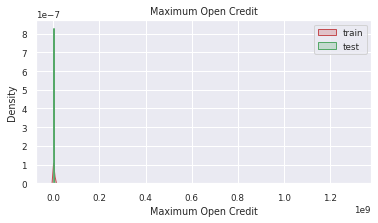

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


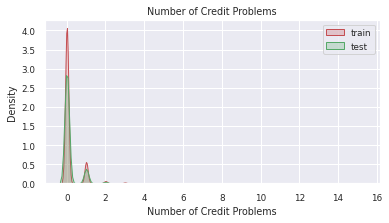

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


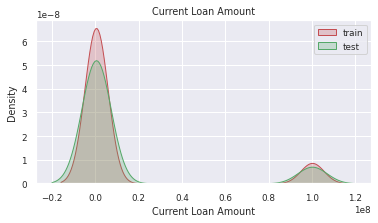

Years in current job
MannwhitneyuResult(statistic=9374527.5, pvalue=0.4984547313663223)


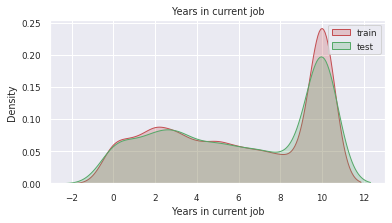

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


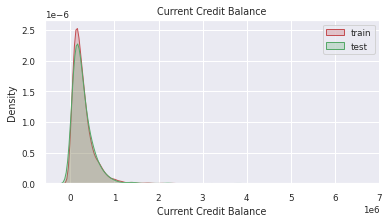

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


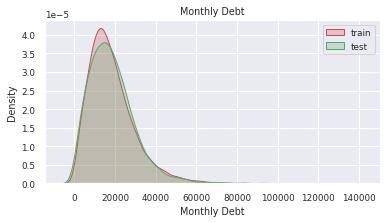

Credit Score
MannwhitneyuResult(statistic=9355026.0, pvalue=0.4361860976739489)


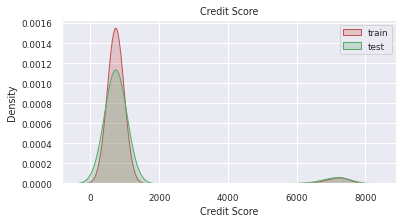

In [55]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df[col], shade=True, label='train', color='r')
    sns.kdeplot(df_final[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df[col], df_final[col]))
    plt.legend()
    plt.title(col)
    plt.show()

### Let's check the distribution of categorical features on the train and test

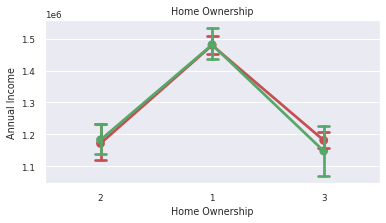

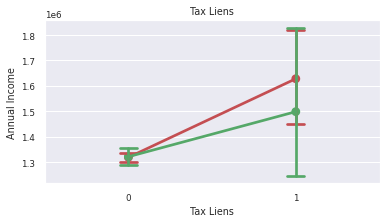

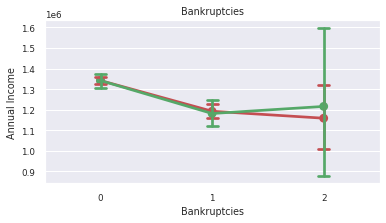

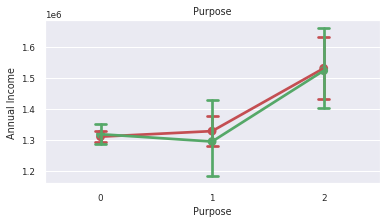

In [56]:
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_final, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

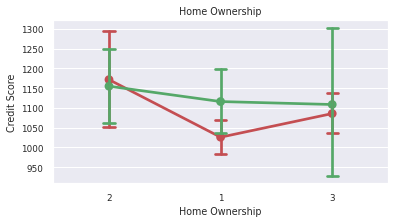

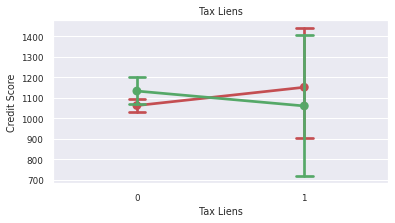

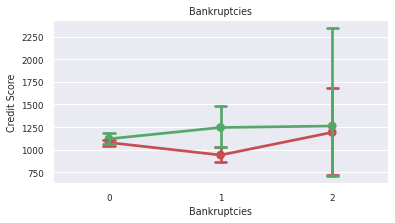

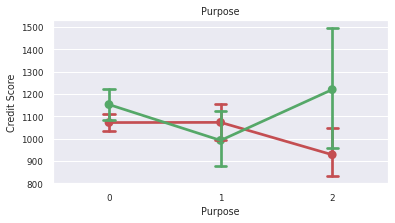

In [57]:
num_feature = 'Credit Score'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_final, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

In [58]:
df.drop('Id',axis=1,inplace=True)

## Saving the training dataset

In [59]:
df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

In [60]:
df_final.to_csv(PREP_TEST_DATASET_PATH, index=False, encoding='utf-8')

## Model Training

In [61]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
       'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default', 'Home Ownership_1',
       'Home Ownership_2', 'Home Ownership_3', 'Purpose_0', 'Purpose_1',
       'Purpose_2', 'Term_1', 'Term_2'],
      dtype='object')

In [62]:
X = df.drop(columns=['Credit Default','Home Ownership','Purpose'])
y = df['Credit Default']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y ,random_state=2)
X_train.shape, X_test.shape

((6000, 21), (1500, 21))

In [64]:
%%time
tree = DecisionTreeClassifier(random_state=1)

param_grid=[{
             'max_depth': range(1, 7), 
             'min_samples_leaf': range(1, 7), 
            }]

grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
tree = grid_search.best_estimator_

CPU times: user 4.55 s, sys: 6.53 ms, total: 4.56 s
Wall time: 4.59 s


In [65]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 1}

In [66]:
pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

pred_proba_test = tree.predict_proba(X_test)
pred_proba_test[:5]

array([[0.87014428, 0.12985572],
       [0.66438356, 0.33561644],
       [0.72817133, 0.27182867],
       [1.        , 0.        ],
       [0.85964912, 0.14035088]])

## Metric count

In [67]:
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

Accuracy на трейне 0.7763333333333333
Accuracy на тесте 0.7606666666666667


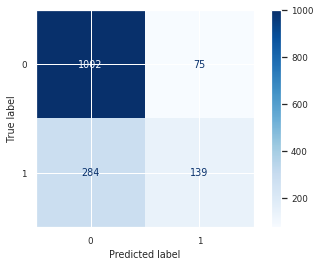

In [68]:
plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

In [69]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1077
           1       0.65      0.33      0.44       423

    accuracy                           0.76      1500
   macro avg       0.71      0.63      0.64      1500
weighted avg       0.74      0.76      0.73      1500



<AxesSubplot:>

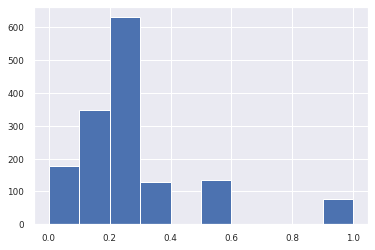

In [70]:
pd.Series(pred_proba_test[:, 1]).hist()

In [71]:
pred_test = np.where(pred_proba_test[:, 1] >= 0.4, 1, 0)

In [72]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      1077
           1       0.65      0.33      0.44       423

    accuracy                           0.76      1500
   macro avg       0.71      0.63      0.64      1500
weighted avg       0.74      0.76      0.73      1500

